In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("HeartDiseaseMortalityAnalysis") \
    .getOrCreate()

# Load the CSV file into a DataFrame
file_path = "Heart_Disease_Mortality_Data_Among_US_Adults__35___by_State_Territory_and_County.csv"
heart_disease_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema and the first few rows of the DataFrame
heart_disease_df.printSchema()
heart_disease_df.show(5)

# Perform some analysis or transformations as needed




root
 |-- Year: integer (nullable = true)
 |-- LocationAbbr: string (nullable = true)
 |-- LocationDesc: string (nullable = true)
 |-- GeographicLevel: string (nullable = true)
 |-- DataSource: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Data_Value: double (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- Data_Value_Type: string (nullable = true)
 |-- Data_Value_Footnote_Symbol: string (nullable = true)
 |-- Data_Value_Footnote: string (nullable = true)
 |-- StratificationCategory1: string (nullable = true)
 |-- Stratification1: string (nullable = true)
 |-- StratificationCategory2: string (nullable = true)
 |-- Stratification2: string (nullable = true)
 |-- TopicID: timestamp (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- Location 1: string (nullable = true)

+----+------------+--------------+---------------+----------+--------------------+--------------------+----------+----------------

In [35]:
# Load the CSV file into a DataFrame
file_path = "Heart_Disease_Mortality_Data_Among_US_Adults__35___by_State_Territory_and_County.csv"
heart_disease_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Selecting relevant columns
selected_df = heart_disease_df.select('Stratification1','Year','LocationAbbr', 'LocationDesc', 'Data_Value')

# Grouping by state and county and calculating average data value
grouped_df = selected_df.groupBy('Stratification1','Year','LocationAbbr', 'LocationDesc').avg('Data_Value')

# Showing the resulting DataFrame
grouped_df.show()
from pyspark.sql.functions import col

# Filter out rows where 'Data_Value' is not null and is of type float or integer
cleaned_df = heart_disease_df.filter((col('Data_Value').isNotNull()) & 
                                     ((col('Data_Value').cast('float').isNotNull()) | 
                                      (col('Data_Value').cast('int').isNotNull())))

# Show the cleaned DataFrame
cleaned_df.show()


+---------------+----+------------+---------------+------------------+
|Stratification1|Year|LocationAbbr|   LocationDesc|   avg(Data_Value)|
+---------------+----+------------+---------------+------------------+
|         Female|2014|          AK| Valdez-Cordova|             212.8|
|           Male|2014|          AL|Randolph County| 716.2333333333332|
|         Female|2014|          AL|  Etowah County| 458.5333333333333|
|         Female|2014|          CA| Alameda County|            178.25|
|         Female|2014|          CO|   Otero County| 248.5666666666667|
|        Overall|2014|          FL|  Citrus County|308.23999999999995|
|           Male|2014|          FL|  Citrus County|426.95000000000005|
|         Female|2014|          FL| Liberty County|268.03333333333336|
|           Male|2014|          GA| Appling County| 650.2666666666667|
|           Male|2014|          GA|  Lanier County|             499.7|
|         Female|2014|          GA|   Upson County| 439.4666666666667|
|     

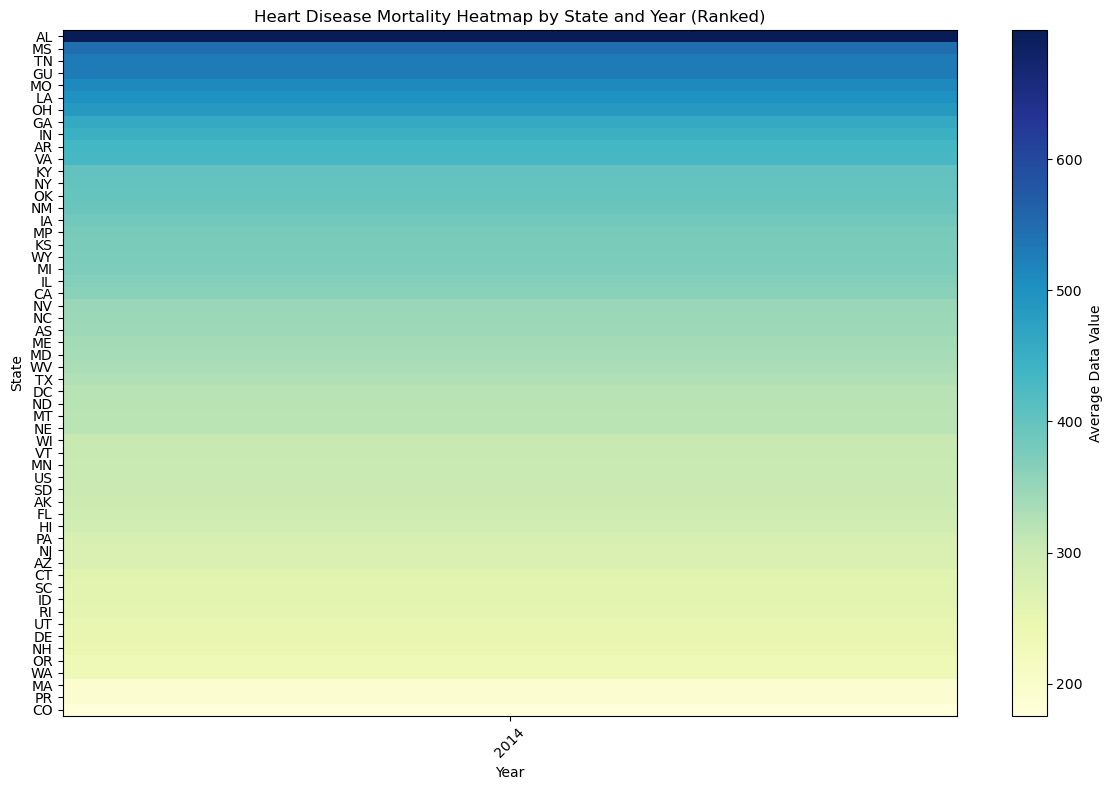

Rank Order:
1. AL: 698.0555555555557
2. MS: 545.7999999999998
3. TN: 530.5222222222222
4. GU: 529.8
5. MO: 510.59999999999997
6. LA: 498.1777777777778
7. OH: 487.5444444444445
8. GA: 458.30000000000007
9. IN: 446.36666666666673
10. AR: 433.65000000000003
11. VA: 428.8888888888889
12. KY: 402.21111111111105
13. NY: 399.7
14. OK: 396.4722222222223
15. NM: 393.5222222222222
16. IA: 385.25
17. MP: 379.1333333333334
18. KS: 376.45000000000005
19. WY: 375.41111111111115
20. MI: 373.66923076923075
21. IL: 365.7
22. CA: 362.47777777777776
23. NV: 347.5111111111111
24. NC: 346.63750000000005
25. AS: 343.5333333333333
26. ME: 337.9333333333333
27. MD: 335.5
28. WV: 332.31666666666666
29. TX: 326.1705882352941
30. DC: 320.0076923076923
31. ND: 319.09999999999997
32. MT: 317.53636363636366
33. NE: 316.9666666666667
34. WI: 303.01666666666665
35. VT: 302.81666666666666
36. MN: 301.91249999999997
37. US: 301.7
38. SD: 299.06666666666666
39. AK: 297.3875
40. FL: 292.67333333333335
41. HI: 288.3727272

In [31]:
import matplotlib.pyplot as plt
import numpy as np
# Remove rows with 'VI' as the state abbreviation in the 'LocationAbbr' column under grouped_df
grouped_df = grouped_df.filter(grouped_df['LocationAbbr'] != 'VI')




# Get unique years and states
years = grouped_df.select('Year').distinct().rdd.flatMap(lambda x: x).collect()
states = grouped_df.select('LocationAbbr').distinct().rdd.flatMap(lambda x: x).collect()

# Create a matrix to store average data values
data_matrix = np.zeros((len(states), len(years)))

# Fill the matrix with average data values
for i, year in enumerate(years):
    year_data = grouped_df.filter(grouped_df['Year'] == year).select('LocationAbbr', 'avg(Data_Value)').collect()
    for j, state in enumerate(states):
        state_data = next((item for item in year_data if item["LocationAbbr"] == state), None)
        if state_data:
            data_matrix[j, i] = state_data['avg(Data_Value)']

# Calculate mean data value for each state
mean_data_values = np.mean(data_matrix, axis=1)

# Sort states based on mean data values
sorted_indices = np.argsort(mean_data_values)[::-1]
sorted_states = [states[i] for i in sorted_indices]
sorted_mean_data_values = mean_data_values[sorted_indices]

# Create the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(data_matrix[sorted_indices, :], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value')
plt.title('Heart Disease Mortality Heatmap by State and Year (Ranked)')
plt.xlabel('Year')
plt.ylabel('State')
plt.xticks(np.arange(len(years)), years, rotation=45)
plt.yticks(np.arange(len(states)), sorted_states)
plt.tight_layout()
plt.show()

# Display rank order
print("Rank Order:")
for rank, state in enumerate(sorted_states, 1):
    print(f"{rank}. {state}: {sorted_mean_data_values[rank-1]}")



In [30]:
# Filter the DataFrame for the state of VI (Virgin Islands)
vi_df = heart_disease_df.filter(heart_disease_df['LocationAbbr'] == 'VI')

# Show only the data values for the state of VI
vi_data_values = vi_df.select('Data_Value').show()


+----------+
|Data_Value|
+----------+
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
|      NULL|
+----------+
only showing top 20 rows



In [36]:
from pyspark.sql.functions import col, avg

# Load the CSV file into a DataFrame
file_path = "Heart_Disease_Mortality_Data_Among_US_Adults__35___by_State_Territory_and_County.csv"
heart_disease_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Select relevant columns
selected_df = heart_disease_df.select('Stratification1', 'Year', 'LocationAbbr', 'LocationDesc', 'Data_Value')

# Group by 'Stratification1', 'Year', 'LocationAbbr', 'LocationDesc', and calculate average data value
grouped_df = selected_df.groupBy('Stratification1', 'Year', 'LocationAbbr', 'LocationDesc').agg(avg('Data_Value').alias('Avg_Data_Value'))

# Filter out rows where 'Stratification1' is neither 'Female' nor 'Male'
filtered_df = grouped_df.filter(col('Stratification1').isin('Female', 'Male'))

# Show the resulting DataFrame after filtering
filtered_df.show()

# Filter out rows where 'Data_Value' is not null and is of type float or integer
cleaned_df = heart_disease_df.filter((col('Data_Value').isNotNull()) & 
                                     ((col('Data_Value').cast('float').isNotNull()) | 
                                      (col('Data_Value').cast('int').isNotNull())))

# Show the cleaned DataFrame
cleaned_df.show()

+---------------+----+------------+--------------------+------------------+
|Stratification1|Year|LocationAbbr|        LocationDesc|    Avg_Data_Value|
+---------------+----+------------+--------------------+------------------+
|         Female|2014|          AK|      Valdez-Cordova|             212.8|
|           Male|2014|          AL|     Randolph County| 716.2333333333332|
|         Female|2014|          AL|       Etowah County| 458.5333333333333|
|         Female|2014|          CA|      Alameda County|            178.25|
|         Female|2014|          CO|        Otero County| 248.5666666666667|
|           Male|2014|          FL|       Citrus County|426.95000000000005|
|         Female|2014|          FL|      Liberty County|268.03333333333336|
|           Male|2014|          GA|      Appling County| 650.2666666666667|
|           Male|2014|          GA|       Lanier County|             499.7|
|         Female|2014|          GA|        Upson County| 439.4666666666667|
|           

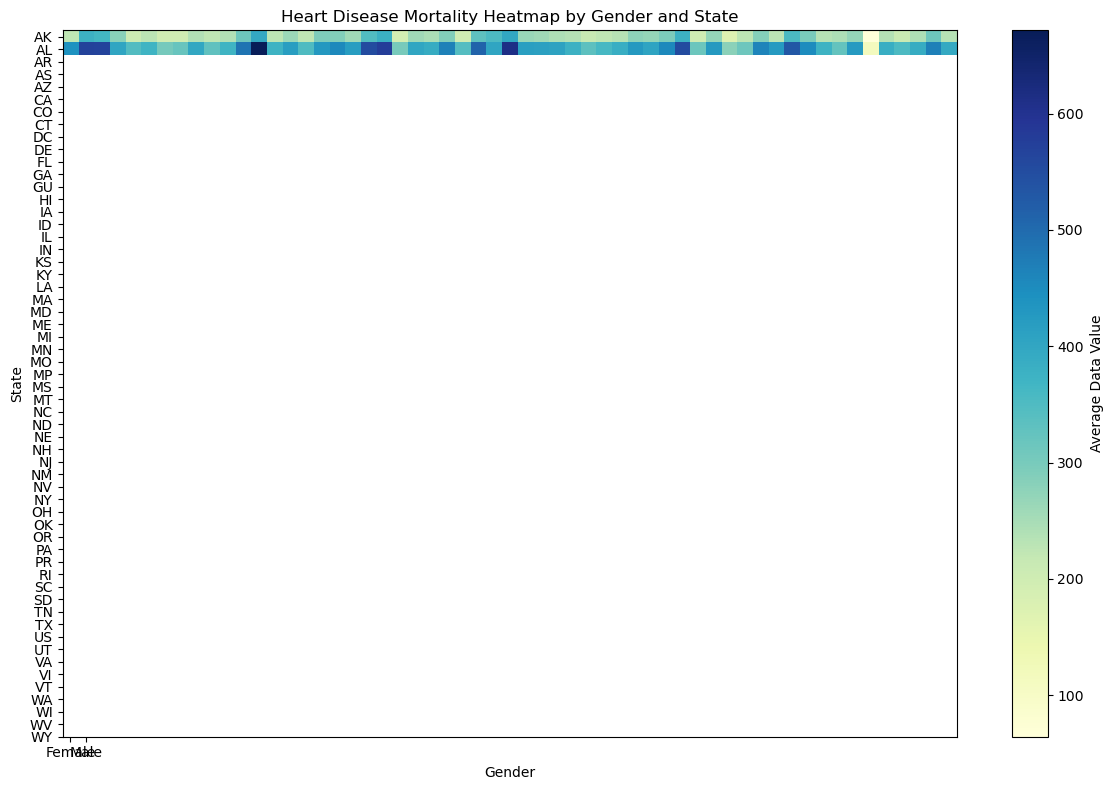

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import avg, when

# Group by LocationAbbr (state abbreviation) and Gender,
# and calculate the average Data_Value for each combination
pivoted_df = grouped_df.groupBy('LocationAbbr').\
    agg(
        avg(when(col('Stratification1') == 'Female', col('Avg_Data_Value'))).alias('Female'),
        avg(when(col('Stratification1') == 'Male', col('Avg_Data_Value'))).alias('Male')
    ).orderBy('LocationAbbr')

# Extract data for plotting
states = pivoted_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
female_data = pivoted_df.select('Female').rdd.flatMap(lambda x: x).collect()
male_data = pivoted_df.select('Male').rdd.flatMap(lambda x: x).collect()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow([female_data, male_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value')
plt.title('Heart Disease Mortality Heatmap by Gender and State')
plt.xlabel('Gender')
plt.ylabel('State')
plt.xticks(np.arange(2), ['Female', 'Male'])
plt.yticks(np.arange(len(states)), states)
plt.tight_layout()
plt.show()


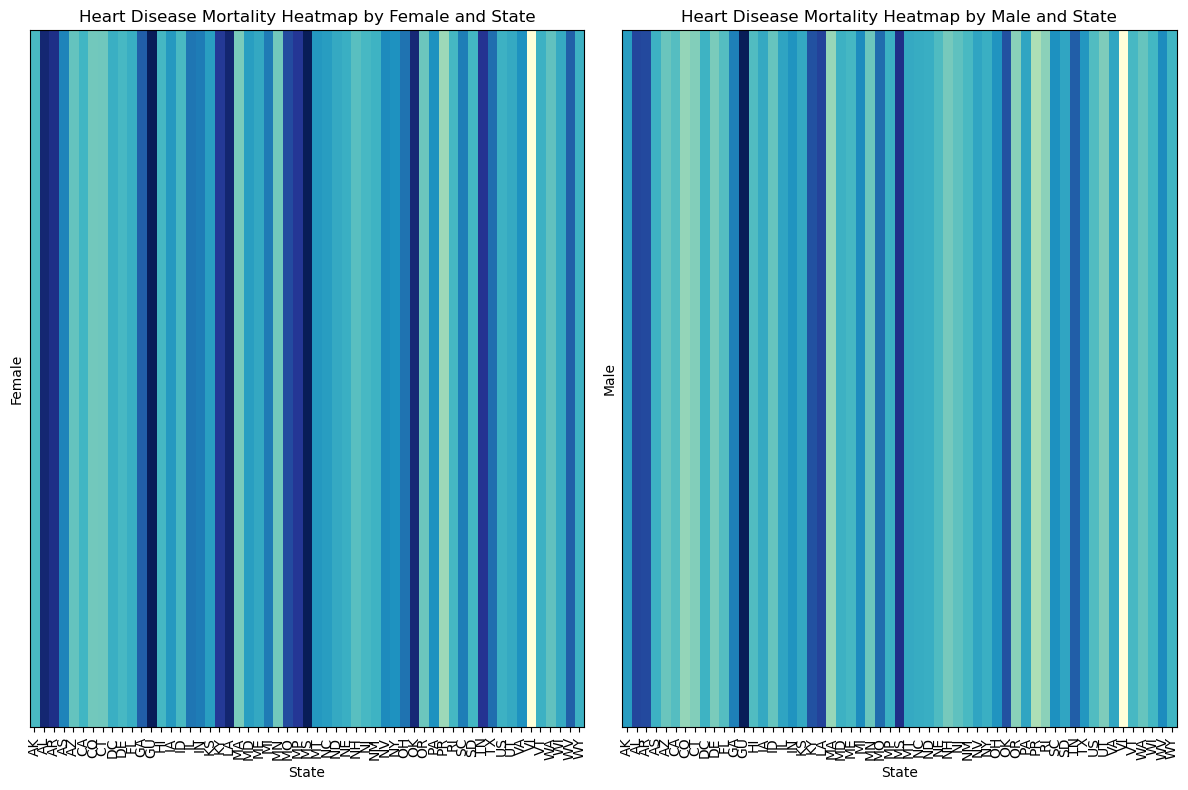

In [43]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plot Female heatmap
ax1.imshow([female_data], cmap='YlGnBu', aspect='auto')
ax1.set_title('Heart Disease Mortality Heatmap by Female and State')
ax1.set_xlabel('State')
ax1.set_ylabel('Female')
ax1.set_xticks(np.arange(len(states)))
ax1.set_xticklabels(states, rotation=90)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Plot Male heatmap
ax2.imshow([male_data], cmap='YlGnBu', aspect='auto')
ax2.set_title('Heart Disease Mortality Heatmap by Male and State')
ax2.set_xlabel('State')
ax2.set_ylabel('Male')
ax2.set_xticks(np.arange(len(states)))
ax2.set_xticklabels(states, rotation=90)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Adjust layout
plt.tight_layout()
plt.show()



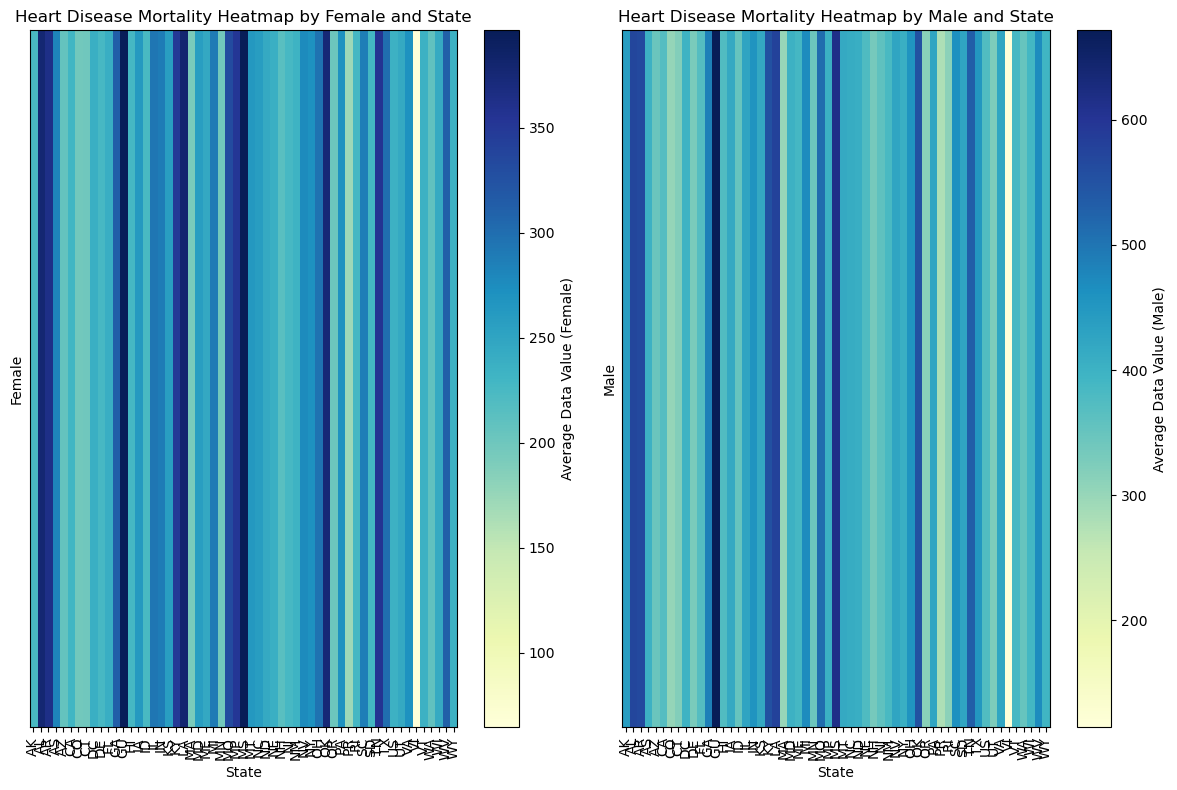

In [45]:
# Filter data for Female and Male genders
female_df = pivoted_df.select('LocationAbbr', 'Female').orderBy('LocationAbbr')
male_df = pivoted_df.select('LocationAbbr', 'Male').orderBy('LocationAbbr')

# Extract data for plotting
states = female_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
female_data = female_df.select('Female').rdd.flatMap(lambda x: x).collect()
male_data = male_df.select('Male').rdd.flatMap(lambda x: x).collect()

# Plot the heatmaps for Female and Male genders
plt.figure(figsize=(12, 8))

# Plot Female heatmap
plt.subplot(1, 2, 1)
plt.imshow([female_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Female)')
plt.title('Heart Disease Mortality Heatmap by Female and State')
plt.xlabel('State')
plt.ylabel('Female')
plt.xticks(np.arange(len(states)), states, rotation=90)
plt.yticks([])

# Plot Male heatmap
plt.subplot(1, 2, 2)
plt.imshow([male_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Male)')
plt.title('Heart Disease Mortality Heatmap by Male and State')
plt.xlabel('State')
plt.ylabel('Male')
plt.xticks(np.arange(len(states)), states, rotation=90)
plt.yticks([])

plt.tight_layout()
plt.show()



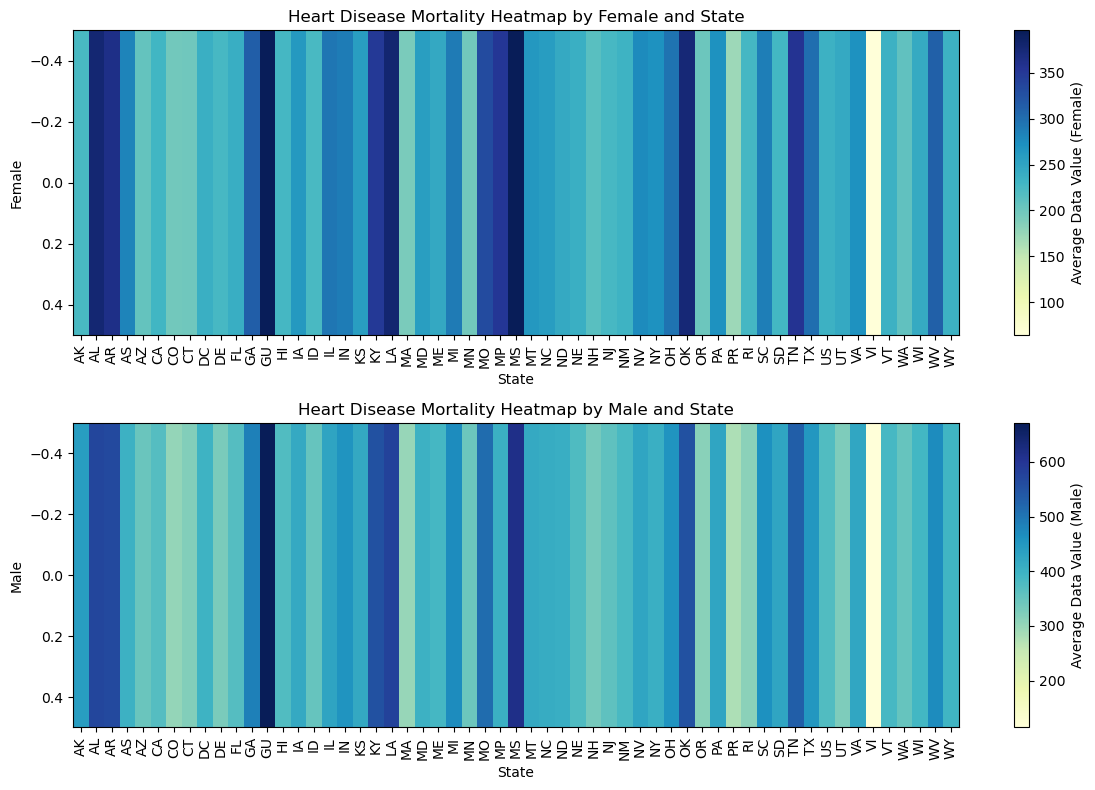

In [46]:
# Filter data for Female and Male genders
female_df = pivoted_df.select('LocationAbbr', 'Female').orderBy('LocationAbbr')
male_df = pivoted_df.select('LocationAbbr', 'Male').orderBy('LocationAbbr')

# Extract data for plotting
states = female_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
female_data = female_df.select('Female').rdd.flatMap(lambda x: x).collect()
male_data = male_df.select('Male').rdd.flatMap(lambda x: x).collect()

# Plot the heatmaps for Female and Male genders with states on the x-axis
plt.figure(figsize=(12, 8))

# Plot Female heatmap
plt.subplot(2, 1, 1)
plt.imshow([female_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Female)')
plt.title('Heart Disease Mortality Heatmap by Female and State')
plt.xlabel('State')
plt.ylabel('Female')
plt.xticks(np.arange(len(states)), states, rotation=90)

# Plot Male heatmap
plt.subplot(2, 1, 2)
plt.imshow([male_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Male)')
plt.title('Heart Disease Mortality Heatmap by Male and State')
plt.xlabel('State')
plt.ylabel('Male')
plt.xticks(np.arange(len(states)), states, rotation=90)

plt.tight_layout()
plt.show()


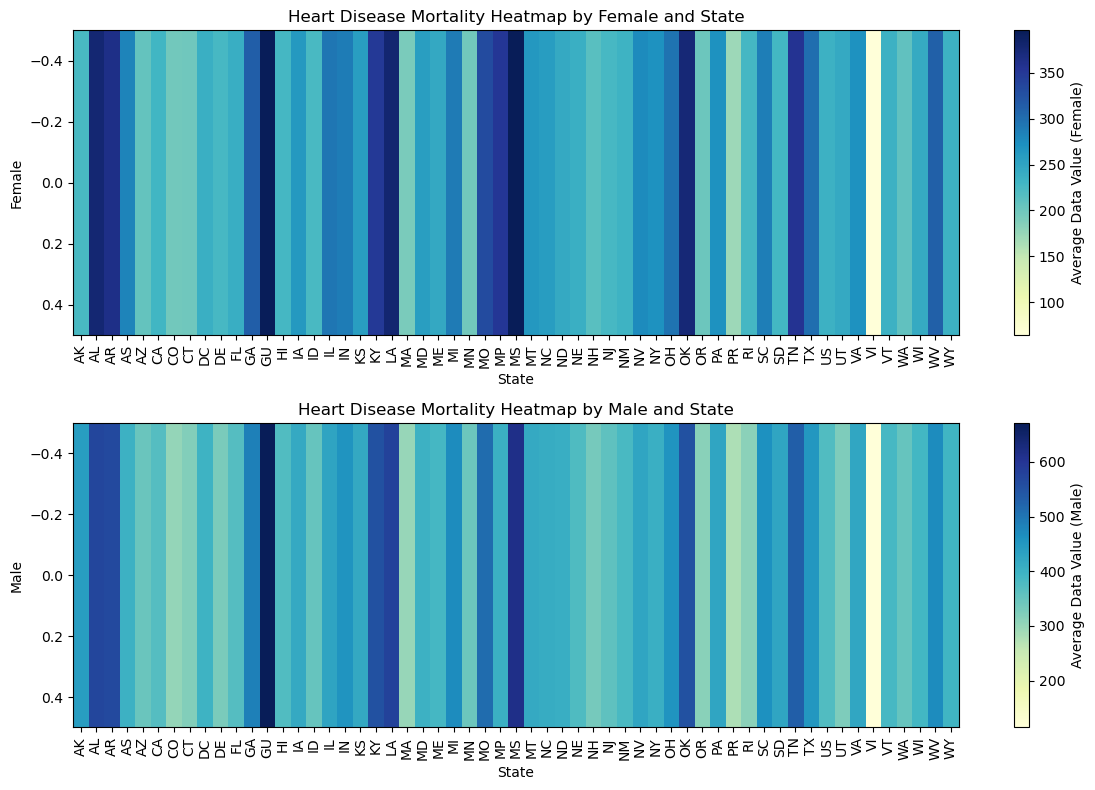

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary DataFrame 'pivoted_df' and it contains the required columns

# Filter data for Female and Male genders
female_df = pivoted_df.select('LocationAbbr', 'Female').orderBy('LocationAbbr')
male_df = pivoted_df.select('LocationAbbr', 'Male').orderBy('LocationAbbr')

# Extract data for plotting
states = female_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
female_data = female_df.select('Female').rdd.flatMap(lambda x: x).collect()
male_data = male_df.select('Male').rdd.flatMap(lambda x: x).collect()

# Plot the heatmaps for Female and Male genders with states on the x-axis
plt.figure(figsize=(12, 8))

# Plot Female heatmap
plt.subplot(2, 1, 1)
plt.imshow([female_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Female)')
plt.title('Heart Disease Mortality Heatmap by Female and State')
plt.xlabel('State')
plt.ylabel('Female')
plt.xticks(np.arange(len(states)), states, rotation=90)

# Plot Male heatmap
plt.subplot(2, 1, 2)
plt.imshow([male_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Male)')
plt.title('Heart Disease Mortality Heatmap by Male and State')
plt.xlabel('State')
plt.ylabel('Male')
plt.xticks(np.arange(len(states)), states, rotation=90)

plt.tight_layout()
plt.show()


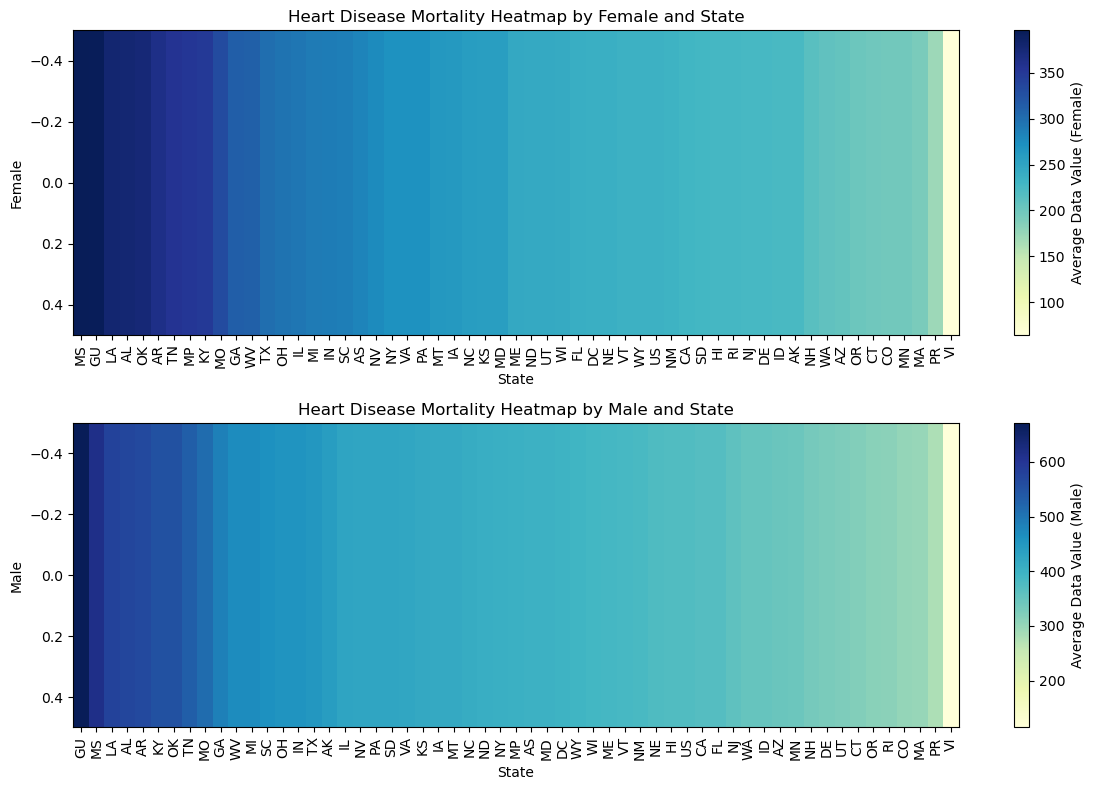

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary DataFrame 'pivoted_df' and it contains the required columns

# Filter data for Female and Male genders
female_df = pivoted_df.select('LocationAbbr', 'Female').orderBy('Female', ascending=False)
male_df = pivoted_df.select('LocationAbbr', 'Male').orderBy('Male', ascending=False)

# Extract data for plotting
states_female = female_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
female_data = female_df.select('Female').rdd.flatMap(lambda x: x).collect()

states_male = male_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
male_data = male_df.select('Male').rdd.flatMap(lambda x: x).collect()

# Plot the heatmaps for Female and Male genders with states on the x-axis
plt.figure(figsize=(12, 8))

# Plot Female heatmap
plt.subplot(2, 1, 1)
plt.imshow([female_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Female)')
plt.title('Heart Disease Mortality Heatmap by Female and State')
plt.xlabel('State')
plt.ylabel('Female')
plt.xticks(np.arange(len(states_female)), states_female, rotation=90)

# Plot Male heatmap
plt.subplot(2, 1, 2)
plt.imshow([male_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Male)')
plt.title('Heart Disease Mortality Heatmap by Male and State')
plt.xlabel('State')
plt.ylabel('Male')
plt.xticks(np.arange(len(states_male)), states_male, rotation=90)

plt.tight_layout()
plt.show()


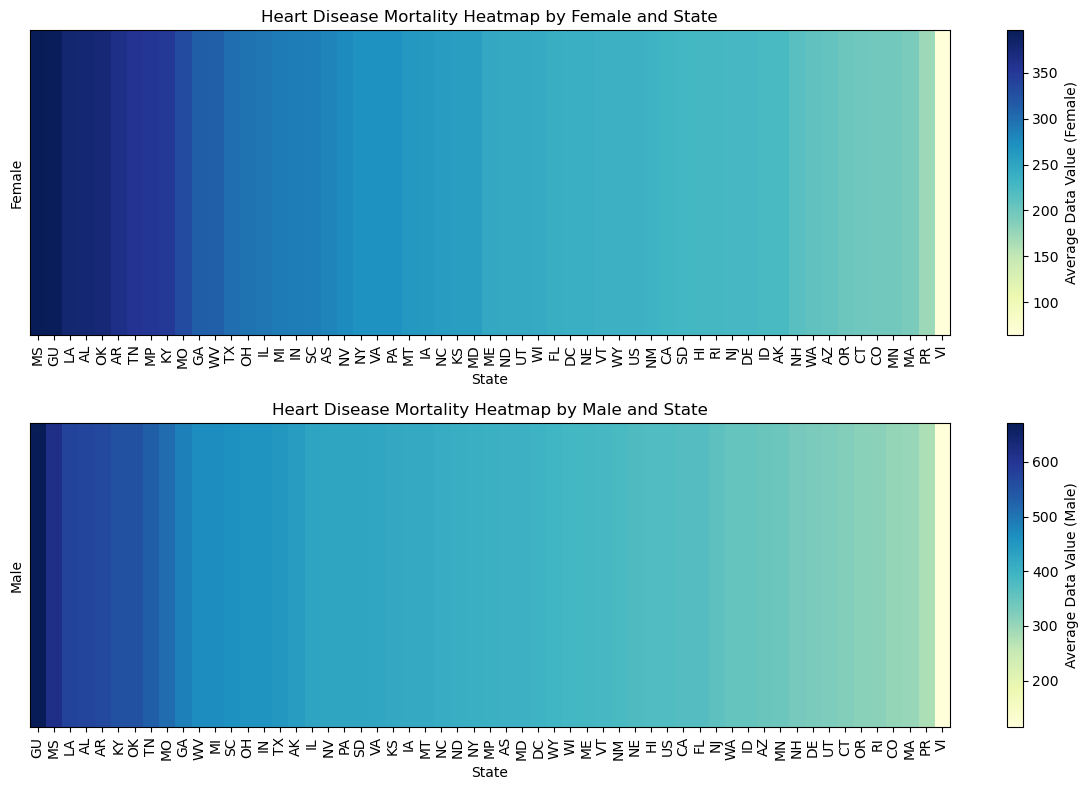

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary DataFrame 'pivoted_df' and it contains the required columns

# Filter data for Female and Male genders
female_df = pivoted_df.select('LocationAbbr', 'Female').orderBy('Female', ascending=False)
male_df = pivoted_df.select('LocationAbbr', 'Male').orderBy('Male', ascending=False)

# Extract data for plotting
states_female = female_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
female_data = female_df.select('Female').rdd.flatMap(lambda x: x).collect()

states_male = male_df.select('LocationAbbr').rdd.flatMap(lambda x: x).collect()
male_data = male_df.select('Male').rdd.flatMap(lambda x: x).collect()

# Plot the heatmaps for Female and Male genders with states on the x-axis
plt.figure(figsize=(12, 8))

# Plot Female heatmap
plt.subplot(2, 1, 1)
plt.imshow([female_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Female)')
plt.title('Heart Disease Mortality Heatmap by Female and State')
plt.xlabel('State')
plt.ylabel('Female')
plt.xticks(np.arange(len(states_female)), states_female, rotation=90)
plt.yticks([])  # Remove y-axis scale

# Plot Male heatmap
plt.subplot(2, 1, 2)
plt.imshow([male_data], cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Average Data Value (Male)')
plt.title('Heart Disease Mortality Heatmap by Male and State')
plt.xlabel('State')
plt.ylabel('Male')
plt.xticks(np.arange(len(states_male)), states_male, rotation=90)
plt.yticks([])  # Remove y-axis scale

plt.tight_layout()
plt.show()
